Import thư viện và Cấu hình

In [29]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from models.SoftMax import SoftMaxClassifier

# Đường dẫn
TRAIN_FILE = '../../data/IRIS_train.csv'
TEST_FILE = '../../data/IRIS_test.csv'
MODEL_FILE = '../models/softmax_model.pkl'

print("Đã import thư viện thành công!")

Đã import thư viện thành công!


## Khởi tạo và Huấn luyện Model

In [30]:
# Set random seed để kết quả reproducible
np.random.seed(42)

# Khởi tạo classifier
clf = SoftMaxClassifier(learning_rate=0.1, epochs=200, batch_size=10)

# Load dữ liệu
X_train, y_train, X_test, y_test = clf.load_data(TRAIN_FILE, TEST_FILE)

# Huấn luyện model
clf.fit(X_train, y_train)

# Lưu model
clf.save_model(MODEL_FILE)

Train: 120 dòng | Test: 30 dòng
Training Mini-Batch (Batch Size: 10, Epochs: 200)...
Epoch 0: Loss = 1.0683
Epoch 100: Loss = 0.3369

[OK] Đã xuất model tại: ../models/softmax_model.pkl


## Đánh giá trên tập Test

In [31]:
# Đánh giá model
acc, y_pred_indices, y_true_indices = clf.evaluate(X_test, y_test)
print(f"\nĐộ chính xác trên tập Test: {acc:.2f}%")

# Chuyển đổi index sang label để hiển thị
CLASS_ORDER = clf.CLASS_ORDER
y_pred_labels = [CLASS_ORDER[idx] for idx in y_pred_indices]
y_true_labels = [CLASS_ORDER[idx] for idx in y_true_indices]

# Load test data để lấy features
df_test = pd.read_csv(TEST_FILE)
X_test_display = df_test[clf.FEATURE_COLS].values

# Tạo DataFrame kết quả
results = pd.DataFrame({
    'Sepal Length': X_test_display[:, 0],
    'Sepal Width': X_test_display[:, 1],
    'Petal Length': X_test_display[:, 2],
    'Petal Width': X_test_display[:, 3],
    'Thực tế': y_true_labels,
    'Dự đoán': y_pred_labels
})

results['Kết quả'] = np.where(results['Thực tế'] == results['Dự đoán'], 'ĐÚNG', 'SAI')

print("\nChi tiết 10 mẫu đầu tiên:")
print(results.head(10))

wrong_cases = results[results['Kết quả'] == 'SAI']
print(f"\nTổng số mẫu dự đoán sai: {len(wrong_cases)}")


Độ chính xác trên tập Test: 93.33%

Chi tiết 10 mẫu đầu tiên:
   Sepal Length  Sepal Width  Petal Length  Petal Width          Thực tế  \
0      0.222222     0.208333      0.338983     0.416667  Iris-versicolor   
1      0.611111     0.333333      0.610169     0.583333  Iris-versicolor   
2      0.666667     0.458333      0.779661     0.958333   Iris-virginica   
3      0.444444     0.500000      0.644068     0.708333  Iris-versicolor   
4      0.083333     0.500000      0.067797     0.041667      Iris-setosa   
5      0.555556     0.583333      0.779661     0.958333   Iris-virginica   
6      0.333333     0.625000      0.050847     0.041667      Iris-setosa   
7      0.583333     0.291667      0.728814     0.750000   Iris-virginica   
8      0.361111     0.208333      0.491525     0.416667  Iris-versicolor   
9      0.694444     0.500000      0.830508     0.916667   Iris-virginica   

           Dự đoán Kết quả  
0  Iris-versicolor    ĐÚNG  
1  Iris-versicolor    ĐÚNG  
2   Iris-virg

## Biểu đồ Loss theo Epoch

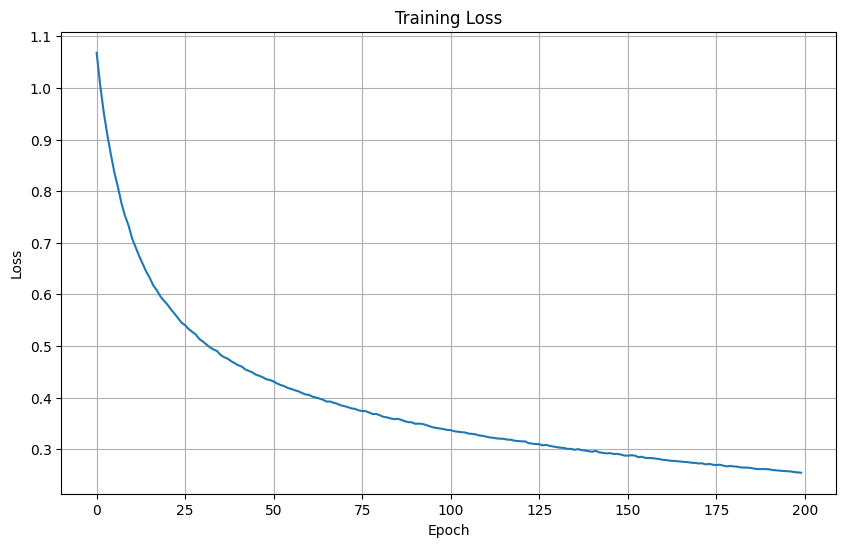

In [32]:
# Vẽ biểu đồ Loss
clf.plot_loss()

Ma trận Tương quan (Correlation Matrix)

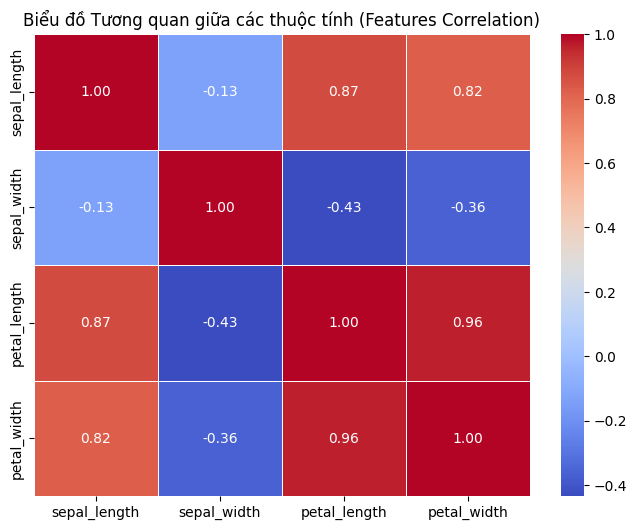

In [33]:
# Tải dữ liệu để xem tương quan
df_train = pd.read_csv(TRAIN_FILE)

# Chỉ lấy 4 cột đặc trưng số
df_features = df_train[clf.FEATURE_COLS]

# Tính ma trận tương quan
corr_matrix = df_features.corr()

# Vẽ Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Biểu đồ Tương quan giữa các thuộc tính (Features Correlation)')
plt.show()

Confusion Matrix (So sánh Thực tế vs Dự đoán)

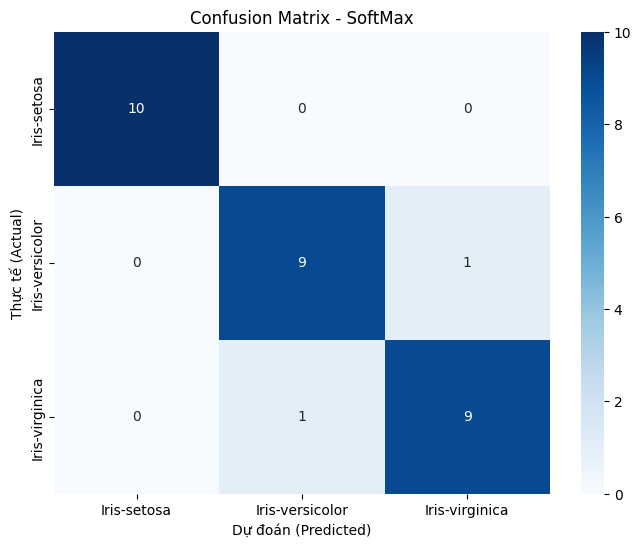

In [34]:
from sklearn.metrics import confusion_matrix

# Tạo Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels, labels=CLASS_ORDER)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_ORDER, yticklabels=CLASS_ORDER)
plt.xlabel('Dự đoán (Predicted)')
plt.ylabel('Thực tế (Actual)')
plt.title('Confusion Matrix - SoftMax')
plt.show()

Trực quan hóa lỗi sai (Scatter Plot)

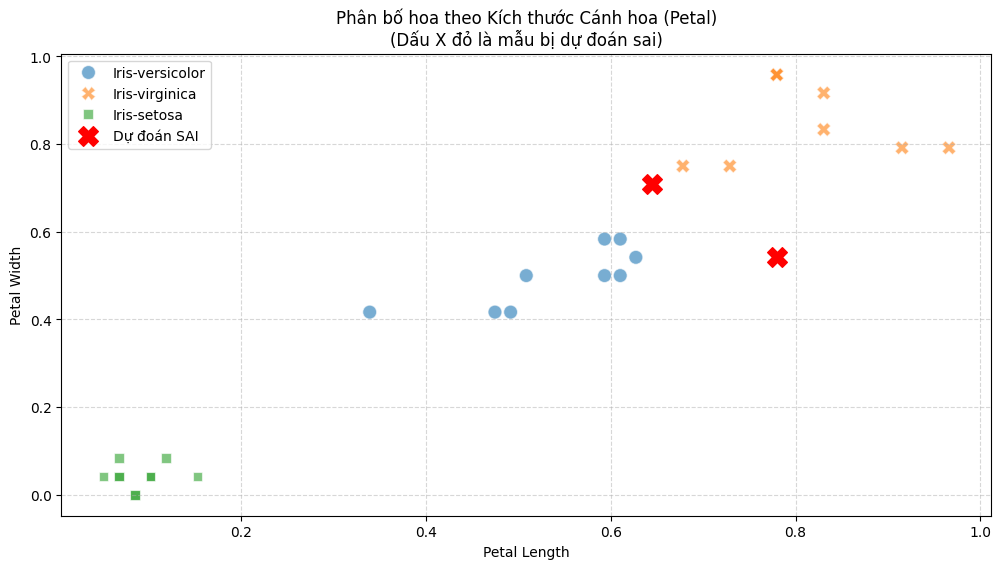

In [35]:
plt.figure(figsize=(12, 6))

# Dữ liệu đúng
correct_data = results[results['Kết quả'] == 'ĐÚNG']
# Dữ liệu sai
wrong_data = results[results['Kết quả'] == 'SAI']

# Vẽ các điểm đúng
sns.scatterplot(data=correct_data, x='Petal Length', y='Petal Width', 
                hue='Thực tế', style='Thực tế', s=100, alpha=0.6)

# Vẽ các điểm sai (đánh dấu X màu đỏ nổi bật)
if not wrong_data.empty:
    plt.scatter(wrong_data['Petal Length'], wrong_data['Petal Width'], 
                color='red', s=200, marker='X', label='Dự đoán SAI')

plt.title('Phân bố hoa theo Kích thước Cánh hoa (Petal)\n(Dấu X đỏ là mẫu bị dự đoán sai)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()